FACTS: <br>
Number of images in training set: N = 416 <br>
Number of Pixels per image: D = 2576 <br>
Number of classes: c = 52 <br>
-> <br>
Sw: rank(Sw)= N-c = 364 -> Mpca <= 364 <br>
Sb: rank(Sb)= c-1 = 51 -> Mlda <= 51 <br>

In [1]:
# Imports
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the source file with the face data
mat_content = sio.loadmat('face.mat')

In [2]:
# Store face data and classification
face_data = mat_content['X']
face_label = mat_content['l'] # Not actually used for PCA training, needed for testing

# Append the matching data and labels into array 'faces': unnecessary for PCA training as the labels are not used (unsupervised learning)
# But we need it later for assessing our algorithms during testing
faces = np.append(face_data, face_label, axis=0)

#Transpose in preparation for division into training and testing material
faces_transposed = faces.T

In [3]:
#create training data by sampling over each class
test_class = np.zeros((104,2577))
train_class = np.zeros((416,2577))
for i in range(52):
    temp_class_set = faces_transposed[i==(faces_transposed[:,-1]-1),:]
    np.random.shuffle(temp_class_set)
    train_class[8*i:(8*i)+8,:] = temp_class_set[:8,:]
    test_class[2*i:(2*i)+2,:]=temp_class_set[8:,:]
    
print(train_class, train_class.shape)
print(test_class, test_class.shape)

[[ 93.  95.  81. ... 100.  91.   1.]
 [ 73.  83. 124. ...  30.  26.   1.]
 [ 65.  66.  65. ...  75.  84.   1.]
 ...
 [188. 186. 195. ...  62.  58.  52.]
 [ 86.  63.  51. ... 107. 120.  52.]
 [ 27.  29.  30. ... 127. 181.  52.]] (416, 2577)
[[191. 185. 174. ...  19.  17.   1.]
 [ 96.  93.  95. ...  85. 121.   1.]
 [ 51.  76.  74. ...  26.  25.   2.]
 ...
 [ 96.  98.  88. ...  40.  41.  51.]
 [ 77.  72.  68. ... 103. 110.  52.]
 [176. 174. 164. ... 149. 140.  52.]] (104, 2577)


In [4]:
#Divide the data set into training and testing sets: 80% is training, 20% is testing
np.random.shuffle(faces_transposed) # Shuffle the rows (This is why we transposed)
#training, test = faces_transposed[:416,:], faces_transposed[416:,:]

#make use of new test and training data
training=train_class
test = test_class

training, testing: axis 0: pictures, axis 1: pixels + label

In [5]:
#order training data depending on their class
training = training[np.argsort(training[:,-1]),:]

# Create a list of arrays depending on the classes
class_sets = []
for i in range(52):
    class_sets.append(training[i==(training[:,-1]-1),:2576])
    
print(class_sets[0],class_sets[0].shape)

# Calculate the class means
#class_means = []
#for c in class_sets:
#    class_means.append(np.mean(c, axis=0))
#print(class_means[0],class_means[0].shape)

class_means = np.zeros((52,2576))
for i in range(52):
    class_means[i,:] = np.mean(class_sets[i], axis=0)

# Calculate the global mean
global_mean = np.mean(training[:,:2576], axis=0)
print(global_mean,global_mean.shape)

#Calculate Sb
class_means_norm = class_means - global_mean #make us of broadcasting
Sb = np.dot(class_means_norm.T, class_means_norm)
#print(np.linalg.matrix_rank(Sb)) # =c-1


[[ 93.  95.  81. ...  88. 100.  91.]
 [ 73.  83. 124. ...  33.  30.  26.]
 [ 65.  66.  65. ...  62.  75.  84.]
 ...
 [161. 156. 141. ...  58.  59.  60.]
 [161. 162. 160. ...  50.  47.  46.]
 [106. 103. 103. ...  37.  36.  41.]] (8, 2576)
[121.79807692 122.51682692 120.19711538 ...  86.37980769  84.68028846
  83.06730769] (2576,)


In [6]:
#Calculate x-mi
class_sets_norm = []
for i in range(52):
    class_sets_norm.append(class_sets[i]-class_means[i,:])
print(class_sets_norm[0].shape)

(8, 2576)


In [7]:
#Calculate Sw
Sw = np.zeros((2576,2576))
for c in class_sets_norm:
    Sw += np.dot(c.T,c)
    
#print(np.linalg.matrix_rank(Sw)) # = N-c

In [8]:
#Calculate St
# Images are represented as rows of the array 'pca_train'
pca_train = training [:, :2576]
pca_train_norm = pca_train - global_mean
St = np.dot(pca_train_norm.T, pca_train_norm)

In [9]:
# Calculate Wpca
eigvals_St, eigvecs_St = np.linalg.eig(St)

# take real part of the eigenvalues (complex eigenvalues are the result of calculation rounding errors)
eigvals_St = np.real(eigvals_St)
eigvecs_St = np.real(eigvecs_St)

#order eigenvectors and eigenvalues according to their size
index_St = eigvals_St.argsort()[::-1]
eigvals_St = eigvals_St[index_St]
eigvecs_St = eigvecs_St[:,index_St]

# We just keep the first n eigenvectors and eigenvalues
Mpca = 350 #<=364
eigvecs_St_best = eigvecs_St[:, :Mpca]
eigvals_St_best = eigvals_St[:Mpca]

#Define Wpca
Wpca = eigvecs_St_best

print(Wpca, Wpca.shape)

[[-0.01415888 -0.01277956 -0.01678321 ...  0.0042812  -0.05505095
   0.02187709]
 [-0.01532683 -0.01267018 -0.0181019  ... -0.02043447  0.02044925
   0.02857598]
 [-0.01619353 -0.01256184 -0.02056209 ...  0.00018875  0.03088193
  -0.00426736]
 ...
 [ 0.00425367  0.04907892  0.00264849 ...  0.04037643  0.02999608
   0.02643751]
 [ 0.00419445  0.04865444  0.0031712  ...  0.00741028  0.04725846
   0.0112714 ]
 [ 0.00405676  0.04893925  0.00443705 ...  0.01596199  0.02423301
  -0.04109209]] (2576, 350)


In [10]:
#calculate inverse of Sw_reduced times Sb_reduced
LDA = np.linalg.inv(Wpca.T.dot(Sw).dot(Wpca)).dot(Wpca.T.dot(Sb).dot(Wpca))

print(LDA, LDA.shape)

[[ 1.70054280e+01 -3.35964506e+00  5.50769084e+00 ... -2.59124996e-03
  -1.11038208e-02  1.29362384e-02]
 [-6.22077250e+00  7.41180025e+00 -5.01608141e+00 ...  1.71671232e-02
   3.22796544e-03 -7.26261843e-03]
 [ 1.21503379e+01 -5.97630093e+00  1.06864093e+01 ...  3.95561106e-03
  -1.52938716e-02  1.52246197e-02]
 ...
 [-9.11457909e+00  3.26117354e+01  6.30698922e+00 ...  7.58013881e-01
  -1.88459849e-01 -1.82907828e-01]
 [-3.92755182e+01  6.16633954e+00 -2.45215613e+01 ... -1.89513875e-01
   4.94373938e-01 -1.50759932e-01]
 [ 4.64145752e+01 -1.40730644e+01  2.47613329e+01 ... -1.86574098e-01
  -1.52926525e-01  7.49976285e-01]] (350, 350)


[ 1.96297900e+02  1.42577326e+02  7.54001577e+01  6.06308528e+01
  4.76468481e+01  3.71463712e+01  2.93267579e+01  2.75407087e+01
  2.70247077e+01  1.78500823e+01  1.64158047e+01  1.43870080e+01
  1.24186582e+01  1.15747782e+01  9.89595693e+00  8.73763479e+00
  7.57466030e+00  7.14750934e+00  5.91270916e+00  5.77601900e+00
  5.37638846e+00  4.93733003e+00  4.33894828e+00  3.97860105e+00
  3.68057905e+00  3.23693517e+00  3.12311596e+00  2.90836801e+00
  2.69225218e+00  2.48353690e+00  2.31305704e+00  2.08677253e+00
  1.80469572e+00  1.70260377e+00  1.55016867e+00  1.41969489e+00
  1.26316750e+00  1.14667545e+00  1.06994180e+00  9.20281095e-01
  9.03358038e-01  8.68322229e-01  8.02574964e-01  7.17922803e-01
  6.00491771e-01  5.84489574e-01  5.46258983e-01  5.03666024e-01
  4.50755337e-01  3.66047945e-01  2.62656291e-01  1.45547114e-14
  1.37195802e-14  1.37195802e-14  1.04535076e-14  1.04535076e-14
  9.43869518e-15  8.69782281e-15  8.69782281e-15  8.18607482e-15
  8.18607482e-15  8.12419

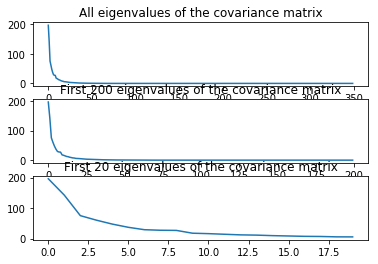

[[ 0.00384555  0.01340211 -0.00568506 ... -0.00189256 -0.0031352
  -0.00089856]
 [-0.0011351  -0.01078877 -0.00471651 ...  0.00282462  0.00030732
   0.00124988]
 [-0.00281018  0.01910099  0.00220846 ...  0.00145252  0.00089112
  -0.00096156]
 ...
 [-0.09485204  0.00227357 -0.12889738 ... -0.21274605  0.15236088
  -0.16262432]
 [ 0.02240176 -0.10462095  0.03778553 ... -0.02099079  0.08432912
   0.07459086]
 [ 0.04396374  0.0978433   0.10281747 ... -0.04472317  0.00024432
  -0.22308704]] (350, 50)


In [11]:
#calculate Wlda
#Get the generalised eigenvectors of LDA_matrix with largest Mlda eigenvalues
eigvals_LDA, eigvecs_LDA = np.linalg.eig(LDA)

# take real part of the eigenvalues (complex eigenvalues are the result of calculation rounding errors)
eigvals_LDA = np.real(eigvals_LDA)
eigvecs_LDA = np.real(eigvecs_LDA)

#order eigenvectors and eigenvalues according to their size
index_LDA = eigvals_LDA.argsort()[::-1]
eigvals_LDA = eigvals_LDA[index_LDA]
eigvecs_LDA = eigvecs_LDA[:,index_LDA]

x = np.arange(0, 350)
print (eigvals_LDA, eigvals_LDA.shape)

# plot them
plt.subplot(3, 1, 1)
plt.plot(x, eigvals_LDA) # clearly out of scale, so let's just take the first 200 of them
plt.title('All eigenvalues of the covariance matrix')

plt.subplot(3, 1, 2)
plt.plot(x[:200], eigvals_LDA[:200]) # still out of scale, so let's just take the first 20 of them
plt.title('First 200 eigenvalues of the covariance matrix')

plt.subplot(3, 1, 3)
plt.plot(x[:20], eigvals_LDA[:20])
plt.title('First 20 eigenvalues of the covariance matrix')
plt.show()

# We just keep the first Mlda eigenvectors and eigenvalues
Mlda = 50 #<=51
eigvecs_LDA_best = eigvecs_LDA[:, :Mlda]
eigvals_LDA_best = eigvals_LDA[:Mlda]

#Define Wpca
Wlda = eigvecs_LDA_best

print(Wlda, Wlda.shape)

[[ 0.01047762  0.01793646  0.00973344 ...  0.0392241  -0.00395017
   0.02075208]
 [ 0.01815489  0.00934035 -0.02235063 ... -0.01231656 -0.00855541
  -0.03454882]
 [ 0.00013215  0.01023002 -0.01520283 ... -0.0171962   0.00278697
  -0.04565724]
 ...
 [ 0.04987027 -0.00692608 -0.0612296  ... -0.02790584 -0.00415549
   0.00063863]
 [ 0.05265394  0.00016572  0.01406441 ...  0.01521912  0.02242804
   0.0065146 ]
 [-0.02349722  0.00106013  0.02399531 ... -0.01947787 -0.00262476
   0.03975778]] (50, 2576)


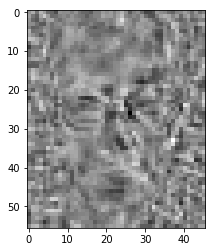

In [12]:
#Calculate Wopt
Wopt_transposed = Wlda.T.dot(Wpca.T)
print(Wopt_transposed,Wopt_transposed.shape)
Wopt = Wopt_transposed.T
plt.imshow(np.reshape(Wopt[:,0], (46,56)).T, cmap = 'gist_gray')

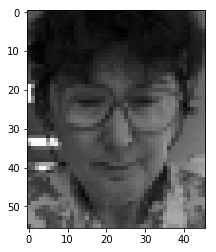

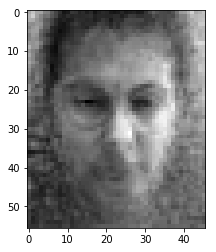

In [13]:
#Reconstruction check
plt.imshow(np.reshape(pca_train[0,:], (46,56)).T, cmap = 'gist_gray')
pic_LDA = Wopt_transposed.dot((pca_train[0,:]-global_mean))
pic_LDA_reconstructed = Wopt.dot(pic_LDA)+global_mean
plt.figure()
plt.imshow(np.reshape(pic_LDA_reconstructed, (46,56)).T, cmap = 'gist_gray')

(2576, 416)
(50, 416)
(2576, 104)
(50, 104)
(416, 104)
[  5   1 127  10  18  20  30  31  32  35  42  43  49  53  61  62  67  69
  23  74  84  84  89  88 102 102 108 110 113 116 122 126 135 127 138 127
 147 151 157 157 164 165 172 169 183 181  30  30 199 192 204 204 209 209
 221 217 245 228 127 230 240 244 252 248 258 262 271 269 159 277 286 286
 295 294 298 297  89 307 127 317 321 321 334 334 343 343 344 269 355 354
 361 127 370 297 382 379 389 390 398 297 406 406 121 413]
[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


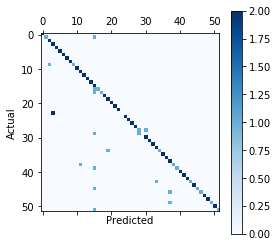

Percentage:  0.8365384615384616


In [14]:
#Predict the class for the test set
#Project train data into LDA space
train_norm = (training[:,:2576] - global_mean).T 
print(train_norm.shape) #each picture is a column
train_LDA = Wopt_transposed.dot(train_norm)
print(train_LDA.shape) #each picture is a column

#Project test data into LDA space
test_norm = (test[:,:2576] - global_mean).T 
print(test_norm.shape) #each picture is a column
test_LDA = Wopt_transposed.dot(test_norm)
print(test_LDA.shape) #each picture is a column

train_LDA_reshape_1 = np.repeat(train_LDA.reshape(Mlda,416,1),104, axis=2) #axis-0: projected values, axis-1: training pictures, axis-2: repeated values
test_LDA_reshape_1 = np.repeat(test_LDA.reshape(Mlda,1,104), 416, axis=1) #axis-0: projected values, axis-1: repeated values, axis-2: test pictures

#Do nearest neighbours
distances = np.linalg.norm(test_LDA_reshape_1-train_LDA_reshape_1, axis=0)
print(distances.shape)

#calculate the nearest training picture
nearest_trainpicture = distances.argmin(axis=0)
print(nearest_trainpicture)

#determine the nearest classes
classes_pred = training[nearest_trainpicture,2576]
classes_act = test[:,2576]

cm = confusion_matrix(classes_act, classes_pred)

print(cm)
plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

percentage = np.sum(classes_pred==classes_act) / len(classes_act)
print("Percentage: ",percentage)


In [15]:
#Predict the class for the test set (average nearest neighbours)
#Project all classes into the LDA-Space
class_sets_LDA = []
for c in class_sets:
    class_sets_LDA.append(Wopt_transposed.dot((c-global_mean).T))
print(class_sets_LDA[0], class_sets_LDA[0].shape)

#calculate the average distance to the class
class_mean_distance = np.zeros((52,104))
for i in range(52):
    train_LDA_reshape_2 = np.repeat(class_sets_LDA[i].reshape(Mlda,class_sets_LDA[i].shape[1],1),104,axis=2)
    test_LDA_reshape_2 = np.repeat(test_LDA.reshape(Mlda,1,104), class_sets_LDA[i].shape[1], axis=1)
    d = np.linalg.norm(test_LDA_reshape_2-train_LDA_reshape_2, axis=0)
    class_mean_distance[i,:]=np.average(d,axis=0)
    
#class_mean_distance is a matrix where each element stores the mean class difference of a test point to a certain class
#axis-0: classes, axis-1: mean distance for each point
print(class_mean_distance.shape)



[[ 7.07367771e-01  7.42543782e-02 -1.35086248e+00  4.62818357e-01
   2.17807261e+00  2.10284903e-01  8.25317968e-01  3.56916233e-01]
 [ 2.94555974e+01  3.07320497e+01  3.14605333e+01  3.07704935e+01
   3.10354911e+01  2.93049417e+01  3.25915602e+01  3.17714537e+01]
 [-6.20324210e+01 -6.27088348e+01 -6.25053327e+01 -6.28832159e+01
  -6.38607925e+01 -6.20832068e+01 -6.31794292e+01 -6.28689482e+01]
 [ 8.81735368e+01  8.64048294e+01  8.78164068e+01  8.79177403e+01
   8.73967192e+01  8.42474149e+01  8.62295880e+01  8.77437010e+01]
 [-1.40450194e+01 -1.81635630e+01 -1.38323293e+01 -1.56146795e+01
  -1.24908287e+01 -1.00515627e+01 -1.34408342e+01 -1.34340212e+01]
 [-2.69166563e+01 -2.75026588e+01 -2.60417980e+01 -2.58264296e+01
  -2.56020390e+01 -2.79914019e+01 -3.02057268e+01 -2.61662759e+01]
 [-3.63344261e+01 -4.09850375e+01 -3.90956766e+01 -3.79328847e+01
  -3.63617113e+01 -3.70968806e+01 -3.65532960e+01 -3.75541870e+01]
 [-2.23495207e+01 -2.05342511e+01 -2.05936532e+01 -2.26022671e+01
  -

[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


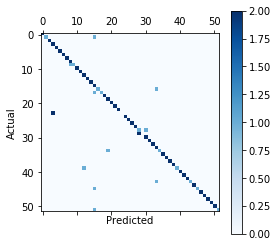

Percentage:  0.8653846153846154


In [16]:
#determine the nearest classes
classes_pred_1 = class_mean_distance.argmin(axis=0)+1 #python index starts from 0 -> add 1
classes_act_1 = test[:,2576]

cm = confusion_matrix(classes_act_1, classes_pred_1)

print(cm)
plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

percentage_1 = np.sum(classes_pred_1==classes_act_1) / len(classes_act_1)
print("Percentage: ",percentage_1)